In [1]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import *
from utils.plot_functions import *
from utils.mog_functions import *


matplotlib.rcParams.update({'font.size': 18})


### Test case "Gaussian"

K
[[ 0.6 -0.4]
 [-0.4  0.6]]

K inv
[[3. 2.]
 [2. 3.]]


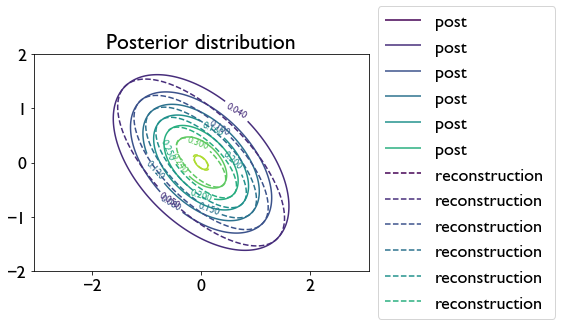

In [2]:
d = 2

y = np.zeros(1)
xmin = -2
xmax = 2
ymin= -2
ymax= 2


# potential function
sigNoise = 1
sigPrior = 1

G = lambda u:  u[0] + u[1] # model
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
I = lambda u: 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2 + Phi(u)

# compute Sigma posterior (the target covariance matrix)
g = np.asarray([[1], [1]])
K_inv = np.eye(d,d)*(1/sigPrior**2) + functools.reduce(np.dot, [g.T, np.eye(d,d)*(1/sigNoise**2),g])
K = np.linalg.solve(K_inv,np.eye(d,d))
print("K")
print(K)
print()
print("K inv")
print(K_inv)

# plot posterior
u0s = np.linspace(xmin,xmax,200) # draw a grid of 150 points in 2d
u1s = np.linspace(ymin,ymax,200)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1)) # size (2, 150, 150)


unnorm_dens = np.exp(-I(U))
Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])

# sanity check
m = np.zeros(2)
cov = K
cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
cov_det = np.linalg.det(cov)  # determinant of covariance matrix
coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
T = coe * np.e ** (-0.5 * (cov_inv[0,0]*(U0-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(U0-m[0])*(U1-m[1]) + cov_inv[1,1]*(U1-m[1])**2))
CS = plt.contour(U0, U1, T, linestyles= "--") # plot a Gaussian of covariance K

plt.clabel(CS, inline=1, fontsize=10)

labels = ['reconstruction ', 'reconstruction','reconstruction','reconstruction',
           'reconstruction', 'reconstruction']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')

plt.title("Posterior distribution")
plt.show()


### Try algorithms

In [3]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 3000 # number of iterations
d = 2 # dimension
tau = 1e-3 # step size

# parameters of our algorithm
const = 1.5 


on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.9289279988533072                                                        
on 0: [[ 1.19348155 -0.15719738]                                                
       [-0.15719738  1.02233448]]


on 0: /Users/annakorba/Desktop/nreks/utils/algorithms.py:286: ComplexWarning: Casting complex values to real discards the imaginary part
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


on 500: iter                                                                    
on 500: 500                                                                     
on 500: lambda min                                                              
on 500: 0.5891818060871341                                                      
on 500: [[ 0.63839308 -0.16500747]                                              
         [-0.16500747  1.14245878]]
on 1000: iter                                                                   
on 1000: 1000                                                                   
on 1000: lambda min                                                             
on 1000: 0.21498389006881108                                                    
on 1000: [[ 0.63997573 -0.3502005 ]                                             
          [-0.3502005   0.50355506]]
on 1500: iter                                                                    ▄▂▂ 1013/3000 [34%] in 13s (~25s, 79

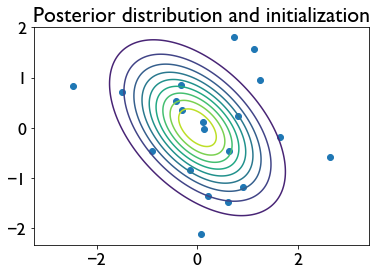

In [4]:
N_exp = 1

for j in range(N_exp):
    
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 
    plt.figure()
    plt.contour(U0, U1, np.exp(-I(U)), 10)
    plt.scatter(u0[0],u0[1])
    plt.axis('equal')
    plt.title("Posterior distribution and initialization")

    # ULA
    """
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    #np.save('save_data/gaussian/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
    #        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")
    

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    #np.save('save_data/gaussian/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
    #                    +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")
    """
    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = 1e-3
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    #np.save('save_data/gaussian/ALDINR_J_'\
    #                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")


In [7]:
# load data


us_list_ULA = np.load('save_data/gaussian/ULA_J_20_Nsim_3000_tau_0.001.npy')
us_list_ALDI = np.load('save_data/gaussian/ALDI_J_20_Nsim_3000_tau_0.001.npy')
us_list_ALDINR = np.load('save_data/gaussian/ALDINR_J_20_Nsim_3000_tau_0.001.npy')

#tau_ALDI = 0.001
#tau_ALDINR = tau_ALDI

TypeError: Shapes of x (150, 150) and z (150, 2) do not match

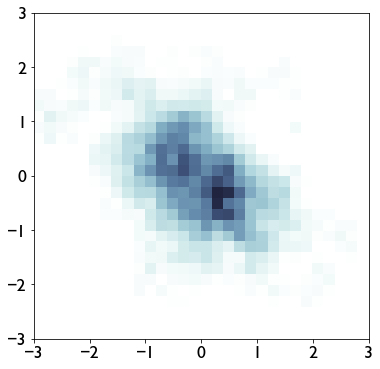

In [8]:
# plot results

val_min, val_max = -3, 3    
    
name = nameof(us_list_ULA).lstrip('us_list')
plot_results(I, us_list_ULA, tau, name, xmin =  val_min, xmax = val_max, ymin = val_min, ymax = val_max)
plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0], color = "purple")
plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red")


name = nameof(us_list_ALDI).lstrip('us_list')
plot_results(I, us_list_ALDI, tau, name, xmin =  val_min, xmax = val_max, ymin = val_min, ymax = val_max)
plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple")
plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red")

    
name = nameof(us_list_ALDINR).lstrip('us_list')
plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  val_min, xmax = val_max, ymin = val_min, ymax = val_max)
plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple")
plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red")



## Plot some statistics for ALDINR

In [ ]:
# compute means and covariances

J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

In [ ]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)


average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Average (over iterations) of the means of particles along iterations (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average (over iterations) of the means along iterations (2nd coordinate)')
plt.tight_layout()

In [ ]:
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]-K) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]-K) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]-K) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C-K along iter')
plt.show()

In [ ]:
traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
plt.show()

### marginal of distribution of particles on last iterations

In [ ]:
binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)

# marginal over x

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDINR')
fig.tight_layout()

# marginal over y

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDINR')
plt.tight_layout()

In [ ]:
j = 0

# load data

us_list_ULA = np.load('save_data/gaussian/ULA_J_20_Nsim_10_tau_0.001_Exp_'+str(j)+'.npy')
us_list_ALDI = np.load('save_data/gaussian/ALDI_J_20_Nsim_10_tau_0.001_Exp_'+str(j)+'.npy')
us_list_ALDINR = np.load('save_data/gaussian/ALDINR_J_20_Nsim_10_tau_0.001_Exp_'+str(j)+'.npy')


# compute means and covariances
J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)

covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J
    
# plot distances to target mean
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

# plot means of particles along iterations

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

# plot historical average (i.e. over iterations) of means of particles

average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
#fig.set_figheight(7)
#fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Historical average of the means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Historical average of the means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]-K) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]-K) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]-K) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C-K along iter')
plt.show()